In [1]:
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


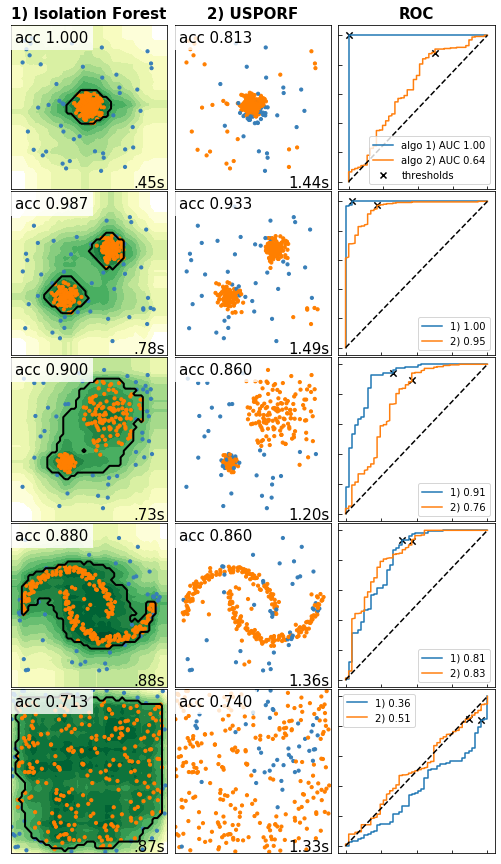

In [107]:
"""
============================================================================
Benchmark performance of different USPORF in 2D toy dataset
============================================================================

This example shows characteristics and compares the performance of USPORF
with different distance matrices on 2D datasets.

Algorithms:
- Isolation Forest, `sklearn.ensemble.IsolationForest`
- Unsupervised Sparse Projection Oblique Randomer Forest(USPORF), 
`UnsupervisedRandomForest`
- RandomTreesEmbedding

RandomTreesEmbedding's distance matrics:
- The depth of the nearest common ancestor of the leaf nodes
- The length of the shortest path of the leaf nodes
- The probability

Benchmarks
- accuracy_score
- roc_auc_score?

"""
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from rerf.urerf import UnsupervisedRandomForest

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import tree
from sklearn import datasets
import matplotlib.cm as cm
from sklearn.ensemble import RandomTreesEmbedding
from scipy import interpolate

# print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# -------------------------------------------------
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_inliers, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_inliers, 2) - 0.5)]

# label the ground truth
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)

# -------------------------------------------------
# algorithm
anomaly_algorithms = [
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         behaviour = "new", random_state=42)),
    (
        "USPORF",
        UnsupervisedRandomForest(
            feature_combinations="auto",
            max_depth=None,
            max_features="auto",
            min_samples_split="auto",
            n_estimators=500,
            n_jobs=None,
            projection_matrix="RerF",
        ),
    ),
]

#-------------------------------------------------------------------
# related functions

# 4.predict outliers from the distance matrics
def decision_function(mat, X, sim_mat):
    """
    Parameters
    ----------
    mat : array-like or sparse matrix, shape (n_samples, n_samples)
        Can be distance matrix, similarity matrix.
    
    X : array-like or sparse matrix, shape (n_samples, n_features)
        The input samples.
    
    sim_mat : bool,
        `True` means `mat` is the distance matrix. `False` means `mat` is the similarity matrix
        
    Returns
    -------
    decision_function : array, shape (n_samples,)
        The anomaly score of the input samples.
        The lower, the more abnormal. Negative scores represent outliers,
        positive scores represent inliers.
    """
    if sim_mat == True: 
        score_samples = (mat**1).sum(axis=1)/X.shape[0] # mean sum square
        # lower score -> more outliers
    if sim_mat == False: 
        score_samples = -(mat**1).sum(axis=1)/X.shape[0] 
        
    offset_ = np.percentile(score_samples, outliers_fraction*100)
    decision_function = score_samples - offset_
    return decision_function
    
def OutPredict(mat, X, sim_mat):
    """
    Parameters
    ----------
    mat : array-like or sparse matrix, shape (n_samples, n_samples)
        Can be distance matrix, similarity matrix.
    
    X : array-like or sparse matrix, shape (n_samples, n_features)
        The input samples.
    
    sim_mat : bool,
        `True` means `mat` is the distance matrix. `False` means `mat` is the similarity matrix
        
    Returns
    -------
    is_inlier : array, shape (n_samples,)
        For each observation, tells whether or not it should
        be considered as inliers (+1) or outliers (-1).
    """
    is_inlier = np.ones(X.shape[0], dtype=int)
    is_inlier[decision_function(mat=mat, X=X, sim_mat=sim_mat) <= 0] = -1
    return is_inlier

# -------------------------------------------------
# plot

# Score Maps
grid_len = np.linspace(-7, 7, 50)
xx, yy = np.meshgrid(grid_len,grid_len)

plt.figure(figsize=((len(anomaly_algorithms)+1) * 2+1, len(datasets)*2.2+1))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

# add outliers
for i_dataset, X in enumerate(datasets):
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)
    
    # list of AUC and ROC
    list_AUC = []
    list_fpr = []
    list_tpr = []
    list_thresh = []
    
    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)

        # fit the data and tag outliers
        if name == "USPORF":
            d_sim = algorithm.transform()
            probas_ = decision_function(mat=d_sim, X=X, sim_mat=True)
            y_pred = OutPredict(mat=d_sim , X=X, sim_mat= True)

        else:
            y_pred = algorithm.fit(X).predict(X)
            probas_ = algorithm.fit(X).decision_function(X)

        AUC = roc_auc_score(y_true, probas_)
        fpr, tpr, thresholds = roc_curve(y_true, probas_)
        thresh_index = np.where(abs(thresholds) == min(abs(thresholds)))[0][0]
        # store ROC curve
        list_AUC.append(AUC)
        list_fpr.append(fpr)
        list_tpr.append(tpr)
        list_thresh.append(thresh_index)

        acc = accuracy_score(y_true, y_pred) # acuracy
        t1 = time.time()
        
        plt.subplot(len(datasets), len(anomaly_algorithms)+1, plot_num)
        if i_dataset == 0:
            plt.title(str(algo_index + 1) + ") " + name, size=15, weight="bold")
        
        # plot the levels lines and the points
        # if name != "Local Outlier Factor":  
        if algo_index <= 0: # only the first three algorithms hase predict function
            lvls = np.linspace(1.1*np.min(probas_),1.1*np.max(probas_),15)
            Score = algorithm.fit(X).decision_function(np.c_[xx.ravel(), yy.ravel()])
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            Score= Score.reshape(xx.shape)
            plt.contourf(xx, yy, Score, lvls, cmap=plt.cm.YlGn)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        
        # show prediction accuracy
        bbox_props = dict(boxstyle="square", fc="white", ec="none", alpha =0.8)
        plt.text(.03, .89, ("acc %.3f" % acc).lstrip("0"),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment="left", bbox = bbox_props)        
        plot_num += 1
        algo_index += 1
        
    #------------------------------------------------------    
    # plot the ROC curves and show AUC scores
    plt.subplot(len(datasets), len(anomaly_algorithms) + 1, plot_num)

    if i_dataset == 0:
        plt.title("ROC", size=15, color="black", weight="bold")
        
        # lebel the decision_function's thresholds
        plt.scatter([], [], marker="x", color="black", label="thresholds")
        
    for algo_index in range(len(anomaly_algorithms)):
        
        if i_dataset == 0:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label="algo " + str(algo_index + 1)+ ")"
                + (" AUC %.2f" % list_AUC[algo_index]).lstrip("0"))
        else:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label= str(algo_index + 1)+ ")"
                + (" %.2f" % list_AUC[algo_index]).lstrip("0"))
        
        plt.scatter(
        list_fpr[algo_index][list_thresh[algo_index]],
        list_tpr[algo_index][list_thresh[algo_index]],
        s=40, marker="x", color = 'black')
            
    plt.plot(np.array([0, 1]), np.array([0, 1]), linestyle="--", color="black")
    plt.legend()
    plt.tick_params(labelleft = False, labelbottom = False, direction  = "in")
    plot_num += 1     
            
plt.show()

<!-- EX1: Among some boserved object 1% belong to a special type (quarsar mixed with many stars) Using a classification method, 99% of these objects can be correctly selected. This method also selects 0.5% of the other types of objects erroneously

What is the probability of having a special type if an object -->